## Predicting heart failure with machine learning

Predicting the likelihood of heart failure based on several risk factors using machine learning.

The dataset is from Davide Chicco & Giuseppe Jurman's study 'Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone' published in BMC Medical Informatics and Decision Making (2020). It contains the medical records of 299 heart failure patients.

### Importing libraries

In [1]:
## Initialising libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras import callbacks


import warnings
warnings.filterwarnings('ignore')

### The data

In [2]:
## Loading the dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
## Checking data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [5]:
## Checking the targets and potential skew in dataset
survivors = pd.DataFrame(df['DEATH_EVENT'].value_counts()).reset_index()
survivors

,DEATH_EVENT,count
0,0,203
1,1,96


Text(0.5, 1.0, 'Survival rate')

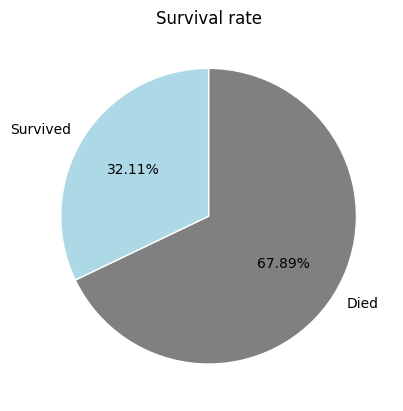

In [6]:
## Plotting the target data
fig, ax = plt.subplots()
labels = ['Died', 'Survived']
colors = ['gray', 'lightblue']
ax.pie(survivors['count'], labels=labels, colors=colors, counterclock = False, startangle=90, autopct='%1.2f%%',
       wedgeprops={"linewidth": 1, "edgecolor": "white"})
ax.set_title('Survival rate')

There's an imbalance in the data between the target and non-target labels.

### Data processing

In [7]:
## Move 'DEATH_EVENT' column to the front of training data for easy viewing
df = df[['DEATH_EVENT'] + [x for x in df.columns if x != 'DEATH_EVENT']]

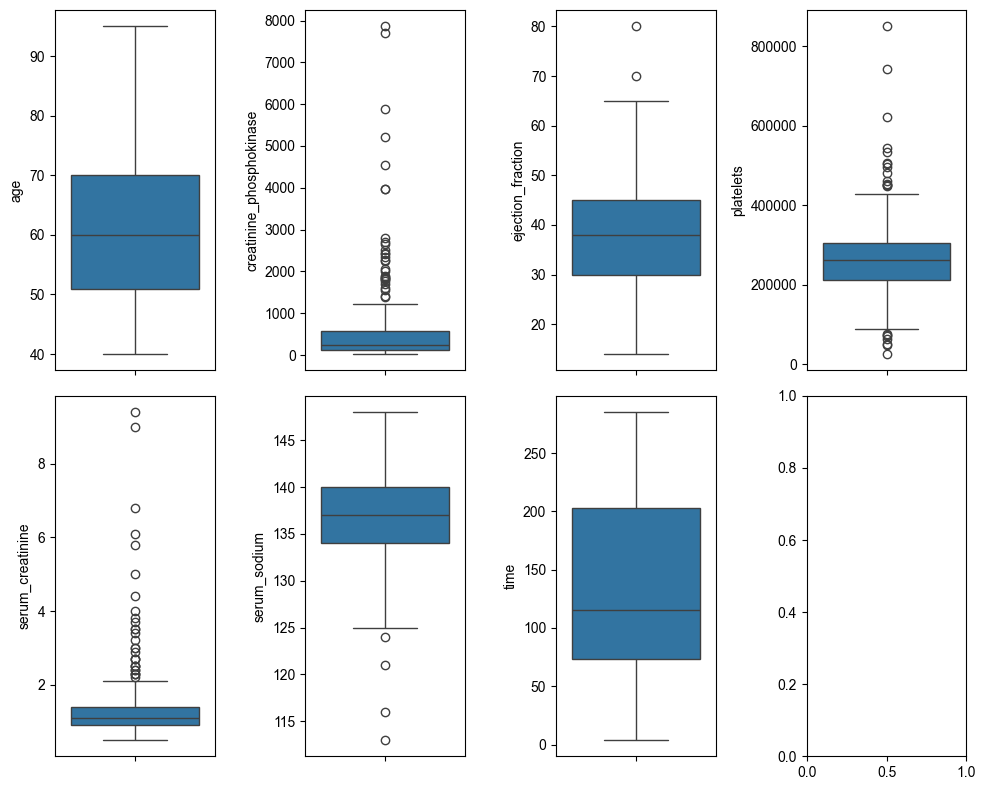

In [8]:
## Plotting the features and checking for outliers
fig, axs = plt.subplots(2, 4, figsize=(10,8))

sns.set_style('darkgrid')
# sns.set(font_scale=0.8)

sns.boxplot(data=df, y='age', ax=axs[0,0])
sns.boxplot(data=df, y='creatinine_phosphokinase', ax=axs[0,1])
sns.boxplot(data=df, y='ejection_fraction', ax=axs[0,2])
sns.boxplot(data=df, y='platelets', ax=axs[0,3])
sns.boxplot(data=df, y='serum_creatinine', ax=axs[1,0])
sns.boxplot(data=df, y='serum_sodium', ax=axs[1,1])
sns.boxplot(data=df, y='time', ax=axs[1,2])

fig.tight_layout()
plt.show()

There are a few outliers in several of the variables, but all are medically possible and likely relevant to the dataset.

In [9]:
## Applying a standard scaler to the values
s_scaler = StandardScaler()

df_scaled = df.copy()
df_scaled.iloc[:, 1:12] = s_scaler.fit_transform(df_scaled.iloc[:, 1:12])
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()

,DEATH_EVENT,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,1,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,4
1,1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,6
2,1,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,7
3,1,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,7
4,1,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,8


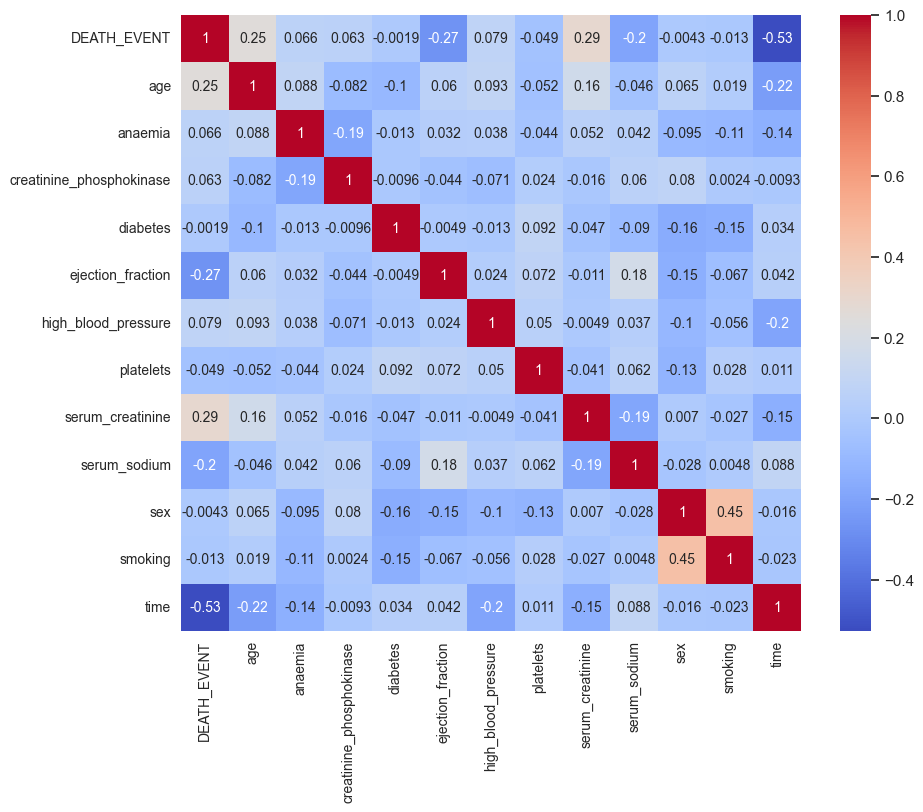

In [10]:
## Plot the heatmap to find correlations
fig, axs = plt.subplots(figsize=(10,8))

corr_mat = df_scaled.corr(numeric_only = True)
sns.set(font_scale=1)
sns.heatmap(corr_mat, annot=True, annot_kws={'size': 10}, cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.show()

### Logistic regression model

In [11]:
# Splitting the data into dependant and independant variables
X = df_scaled.iloc[:, 1:13]
y = df_scaled.iloc[:, 0]

In [12]:
## Split the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=32)

In [13]:
## Train the model
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [14]:
## Making predictions
LR_pred = model_LR.predict(X_test)

In [15]:
## Putting predictions in a df
LR_output = pd.DataFrame({'Actual': y_test, 'Predicted' : LR_pred})
LR_output.head()

,Actual,Predicted
109,0,0
264,0,0
285,0,0
19,1,1
123,0,0


In [16]:
## Evaluate model accuracy
print(classification_report(y_test, LR_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        41
           1       0.78      0.74      0.76        19

    accuracy                           0.85        60
   macro avg       0.83      0.82      0.82        60
weighted avg       0.85      0.85      0.85        60



In [17]:
## Confusion matrix
LR_conf_mat = confusion_matrix(y_test, LR_pred)
print(LR_conf_mat)

[[37  4]
 [ 5 14]]


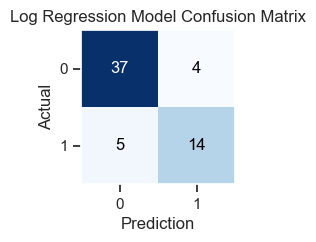

In [18]:
## Confusion matrix plot
fig, ax = plot_confusion_matrix(LR_conf_mat, figsize=(2,2), cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Log Regression Model Confusion Matrix')
plt.show()

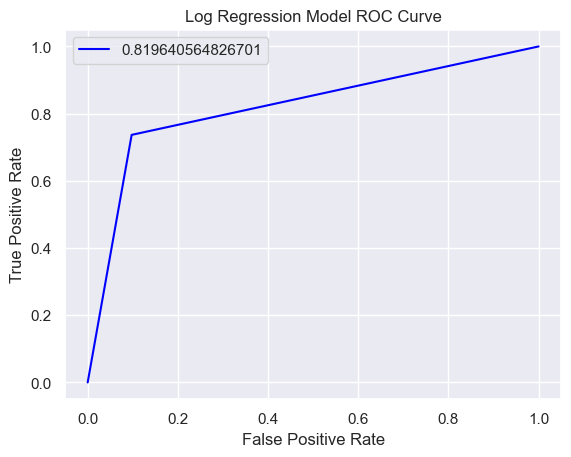

In [19]:
## Plotting the ROC curve
auc_LR = roc_auc_score(y_test, LR_pred)
fpr, tpr, _ = roc_curve(y_test, LR_pred)
plt.plot(fpr, tpr, color = 'blue', label = auc_LR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Regression Model ROC Curve')
plt.legend()
plt.show()

### Random Forest Model

In [20]:
## Create a random forest classifier
rf = RandomForestClassifier()

## Use grid search to find the best hyperparameters
param_grid = { 
    'n_estimators': [25, 50, 100, 150, 200], 
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
} 

grid_search = GridSearchCV(rf, param_grid = param_grid)

grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_) 

RandomForestClassifier(max_depth=3, n_estimators=200)


In [46]:
## Create and fit the model
rf_model = RandomForestClassifier(max_depth=3, n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=200)

In [49]:
## Making predictions
RF_pred = rf_model.predict(X_test)

In [50]:
## Put the predictions in a df
RF_output = pd.DataFrame({'Actual': y_test, 'Predicted': RF_pred})
RF_output.head()

,Actual,Predicted
109,0,0
264,0,0
285,0,0
19,1,1
123,0,0


In [51]:
## Evaluate model accuracy
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        41
           1       0.79      0.79      0.79        19

    accuracy                           0.87        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.87      0.87      0.87        60



In [52]:
## Confusion matrix
RF_conf_mat = confusion_matrix(y_test, RF_pred)
print(RF_conf_mat)

[[37  4]
 [ 4 15]]


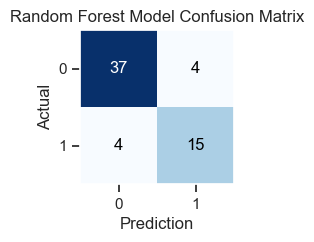

In [53]:
## Confusion matrix plot
fig, ax = plot_confusion_matrix(RF_conf_mat, figsize=(2,2), cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Random Forest Model Confusion Matrix')
plt.show()

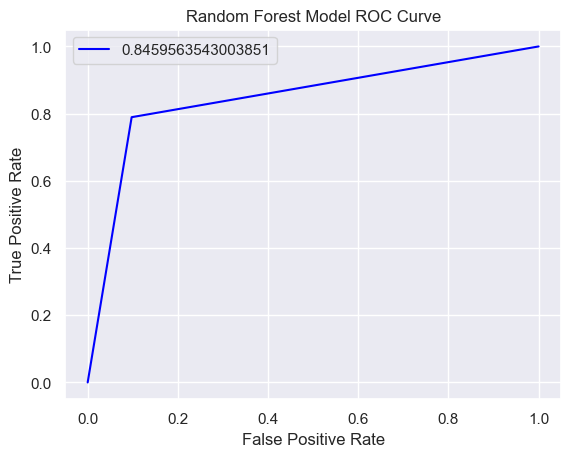

In [54]:
## Plotting the ROC curve
auc_RF = roc_auc_score(y_test, RF_pred)
fpr, tpr, _ = roc_curve(y_test, RF_pred)
plt.plot(fpr, tpr, color = 'blue', label = auc_RF)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model ROC Curve')
plt.legend()
plt.show()

### Combining models with a meta-classifier

Combining models can reduce variance and enhance generalization.

In [55]:
## Combining the logic regression and random forest models
sc_model = StackingClassifier(
    classifiers=[
        LogisticRegression(),
        RandomForestClassifier()
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)

sc_model.fit(X_train, y_train)

StackingClassifier(classifiers=[LogisticRegression(), RandomForestClassifier()],
                   meta_classifier=LogisticRegression(), use_probas=True)

In [56]:
## Making predictions
SC_pred = sc_model.predict(X_test)

In [57]:
## Put the predictions in a df
SC_output = pd.DataFrame({'Actual': y_test, 'Predicted': SC_pred})
SC_output.head()

,Actual,Predicted
109,0,0
264,0,0
285,0,0
19,1,1
123,0,0


In [58]:
## Print classification report
print(classification_report(y_test, SC_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        41
           1       0.80      0.84      0.82        19

    accuracy                           0.88        60
   macro avg       0.86      0.87      0.87        60
weighted avg       0.89      0.88      0.88        60



In [59]:
## Confusion matrix
SC_conf_mat = confusion_matrix(y_test, SC_pred)
print(SC_conf_mat)

[[37  4]
 [ 3 16]]


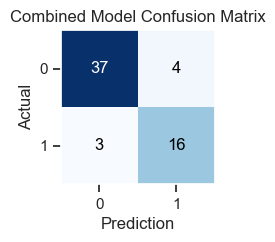

In [60]:
## Confusion matrix plot
fig, ax = plot_confusion_matrix(SC_conf_mat, figsize=(2,2), cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Combined Model Confusion Matrix')
plt.show()

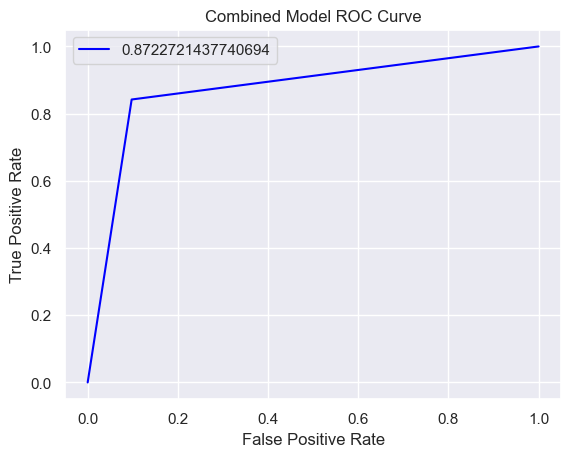

In [61]:
## Plotting the ROC curve
auc_SC = roc_auc_score(y_test, SC_pred)
fpr, tpr, _ = roc_curve(y_test, SC_pred)
plt.plot(fpr, tpr, color = 'blue', label = auc_SC)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined Model ROC Curve')
plt.legend()
plt.show()

### Artificial Neural Network

In [35]:
## Initialise the ANN
model = Sequential()

## Input layers
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

## Hidden layers
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

## Regularization
model.add(Dropout(0.2))

## Output later
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [36]:
## Compile the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                208       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353 (1.38 KB)
Trainable params: 353 (1.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
## Initializing early stopping call-back so the model will stop soon after it reaches the optimal epoch
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=10,
                                        restore_best_weights=True)

In [63]:
## Train the model
history = model.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_split = 0.25, callbacks=[earlystopping])

Epoch 1/200
6/6 [==============================] - 0s 14ms/step - loss: 0.6822 - accuracy: 0.6480 - val_loss: 0.6714 - val_accuracy: 0.7333
Epoch 2/200
6/6 [==============================] - 0s 2ms/step - loss: 0.6709 - accuracy: 0.6592 - val_loss: 0.6550 - val_accuracy: 0.7333
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6592 - val_loss: 0.6327 - val_accuracy: 0.7333
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6592 - val_loss: 0.6041 - val_accuracy: 0.7333
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6592 - val_loss: 0.5706 - val_accuracy: 0.7333
Epoch 6/200
6/6 [==============================] - 0s 3ms/step - loss: 0.6021 - accuracy: 0.6592 - val_loss: 0.5355 - val_accuracy: 0.7333
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 0.5649 - accuracy: 0.6592 - val_loss: 0.5032 - val_accuracy: 0.7333
Epoch 8/200
6/6 [=========

In [64]:
## Save the model
model.save('ann_model')

INFO:tensorflow:Assets written to: ann_model/assets


INFO:tensorflow:Assets written to: ann_model/assets


In [66]:
## Load saved model
ann_model = tf.keras.models.load_model('ann_model')

In [67]:
## Make predictions
ANN_pred = ann_model.predict(X_test)

2/2 [==============================] - 0s 1ms/step


In [68]:
## Set a threshold
ANN_pred = np.where(ANN_pred > 0.5, 1,0)

## Flatten the predictions
ANN_pred = ANN_pred.flatten()

In [69]:
## Put in a dataframe
ANN_output = pd.DataFrame({'Actual': y_test, 'Predicted': ANN_pred})
ANN_output.head()

,Actual,Predicted
109,0,0
264,0,0
285,0,0
19,1,1
123,0,0


In [70]:
## Evaluate model accuracy
print(classification_report(y_test, ANN_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        41
           1       0.76      0.68      0.72        19

    accuracy                           0.83        60
   macro avg       0.81      0.79      0.80        60
weighted avg       0.83      0.83      0.83        60



In [71]:
## Confusion matrix
ANN_conf_mat = confusion_matrix(y_test, ANN_pred)
print(ANN_conf_mat)

[[37  4]
 [ 6 13]]


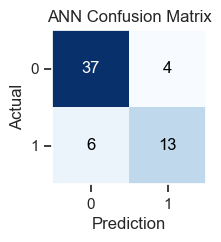

In [72]:
## Confusion matrix plot
fig, ax = plot_confusion_matrix(ANN_conf_mat, figsize=(2,2), cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('ANN Confusion Matrix')
plt.show()

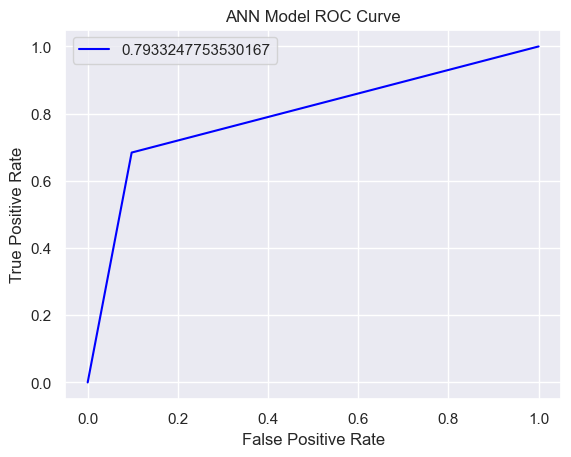

In [73]:
## Plotting the ROC curve
auc_ANN = roc_auc_score(y_test, ANN_pred)
fpr, tpr, _ = roc_curve(y_test, ANN_pred)
plt.plot(fpr, tpr, color = 'blue', label = auc_ANN)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN Model ROC Curve')
plt.legend()
plt.show()